# Corn or Maize Leaf Disease Classification Using Deep Learning

 ## Introduction

- Corn and maize are basic ingredients in many regions across the world. The ears can be roasted and eaten as a vegetable right from the cob, or the kernels can be extracted and used to make a range of meals, including cereals and flour.

- Maize is also a significant source of starch, which can be converted into oils and high-fructose corn syrup.  All of this makes maize and cornmeal very important ingredients, therefore it's understandable why one would want to keep them free of illnesses like Common Rust, Ray Leaf Spot, and Blight.

- These diseases are a major source of concern for maize and corn  growers in Asia, Africa, and the Americas. Plant age, pathogen species, and environment all play a role in symptom expression. The diseases are more common in humid, warm climates.

- As a result, early detection of these diseases is critical in order to mitigate the harm. The main goal of this project is to use <b>EfficientNet</b>, **EfficientNet V2B3** & **ResNet** classify various diseases.

## Importing of Crucial Packages

In [ ]:
import json, cv2, os
import pandas as pd
import numpy as np
from tqdm import tqdm
from collections import defaultdict
from urllib import request
import pandas as pd
import numpy as np
from urllib import request
from tqdm import tqdm
from collections import Counter
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from keras.layers import Dropout, Dense
from keras.models import Model
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.preprocessing.image import ImageDataGenerator
from keras.applications import ResNet152
from keras.applications import DenseNet201
from keras.applications.efficientnet_v2 import EfficientNetV2B3
from sklearn import preprocessing
from sklearn.preprocessing import OrdinalEncoder
from collections import deque

## Importing Dataset from Kaggle

In [ ]:
!pip install -q kaggle
!rm -r ~/.kaggle
!mkdir ~/.kaggle
!mv ./kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d 'smaranjitghose/corn-or-maize-leaf-disease-dataset'

 99% 159M/161M [00:11<00:00, 19.3MB/s]
100% 161M/161M [00:11<00:00, 15.3MB/s]


In [ ]:
! mkdir corn-or-maize-leaf-disease-dataset
! unzip /content/corn-or-maize-leaf-disease-dataset.zip -d corn-or-maize-leaf-disease-dataset

In [ ]:
# file_path='../input/corn-or-maize-leaf-disease-dataset/data'
file_path = '/content/corn-or-maize-leaf-disease-dataset/data'

<h2>Train, Test & Validation Split</h2>

Here, we have used split folders libary to split the data into train test and validation given their ratio.

In [ ]:
!pip install split_folders

In [ ]:
import splitfolders

# fodler to be split
splitted_folder='../content/corn-or-maize-leaf-disease-dataset/splitted_folder'

# making a function to split train, test & valid fodlers
def train_test_valid(train_size=0.6,test_size=0.2,val_size=0.2,images_folder=file_path,splitted_folder=splitted_folder):
  train_size = train_size
  test_size = test_size
  val_size = val_size
  input_folder = images_folder
  output_folder = splitted_folder
  splitfolders.ratio(input_folder,output_folder, seed = 1337, ratio = (train_size,test_size,val_size), group_prefix = None)


train_test_valid()

Copying files: 4188 files [00:00, 6118.72 files/s]


In [ ]:
train_file_path = '../output/corn-or-maize-leaf-disease-dataset/splitted_folder/train'
test_file_path =  '../output/corn-or-maize-leaf-disease-dataset/splitted_folder/test'
val_file_path =  '../output/corn-or-maize-leaf-disease-dataset/splitted_folder/val'

def data_pre_processing(valid_split = 0.2, input_size = (260, 260),
                        image_color = 'rgb',
                        batch_size = 32,
                        shuffle=True):


    train_gen=ImageDataGenerator(rescale=1/255.0,
                                 validation_split=valid_split,
                                 fill_mode='nearest',
                                 rotation_range=40,
                                 horizontal_flip=True)

    validation_gen=ImageDataGenerator(rescale=1/255.0,
                                      validation_split=valid_split)

    test_gen=ImageDataGenerator(rescale=1/255.0)

    train_data=train_gen.flow_from_directory(directory=train_file_path,target_size=input_size,color_mode=image_color,
                                             batch_size=batch_size,shuffle=shuffle,class_mode='categorical')

    test_data=test_gen.flow_from_directory(directory=test_file_path,target_size=input_size,color_mode=image_color,
                                             batch_size=batch_size,shuffle=shuffle,class_mode='categorical')

    valid_data=validation_gen.flow_from_directory(directory=val_file_path,target_size=input_size,color_mode=image_color,
                                             batch_size=batch_size,shuffle=shuffle,class_mode='categorical')

    return train_data,test_data,valid_data

train,test,validation=data_pre_processing()

Found 2511 images belonging to 4 classes.
Found 841 images belonging to 4 classes.
Found 836 images belonging to 4 classes.


 ## Exploring the Daatset
 It can be shown that Gray Leaf spot contains less images than the other images, hence it can affect on the results. We'll add class weights in order to address this problem.

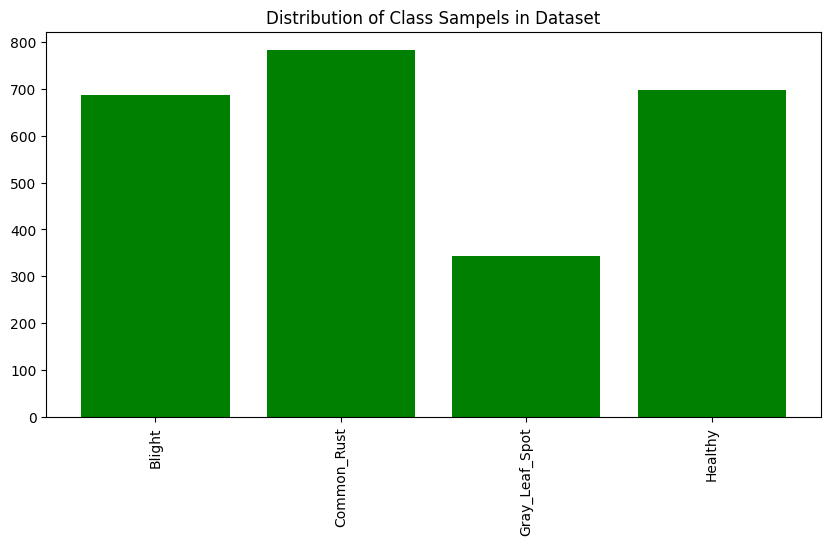

In [ ]:
values_counter=Counter(train.classes)

# sort the collections
sorted(values_counter.items())

# plotting a bar graph
plt.figure(figsize=(10, 5))
plt.title('Distribution of Class Sampels in Dataset')
plt.bar(train.class_indices.keys(), values_counter.values(),
        color=('green'))
plt.xticks(rotation=90)
plt.show()

In [ ]:
labels = dict()

for label_name,label_num in train.class_indices.items():
        labels[label_num]=label_name

100%|██████████| 9/9 [00:05<00:00,  1.60it/s]


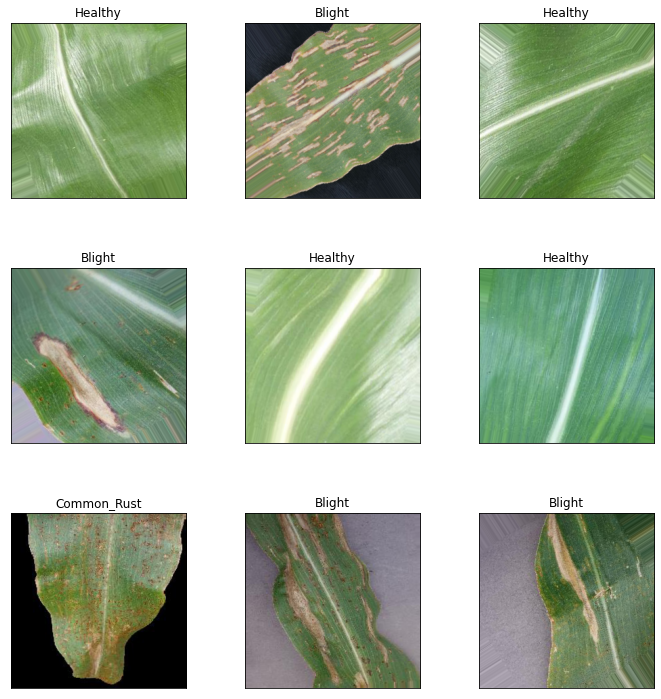

In [ ]:
plt.figure(figsize=(10, 10))
for i in tqdm(range(9)):
    plt.subplot(3, 3, i+1)
    for x_batch,y_batch in train:
        image=x_batch[0]
        argmax=np.argmax(y_batch)
        plt.tight_layout(h_pad=5)
        plt.title(labels[argmax])
        plt.xticks(())
        plt.yticks(())
        plt.imshow(image)
        break

## Making a Deep Learning Model

We have used <b>EfficientNet</b>, **DenseNet** & **ResNet** as the pre-trained models for classification, with unfreezing all layers since the original data was trained for different task.

In [ ]:
# installing efficientnet library
!pip install  efficientnet

# import model
import efficientnet.tfkeras as enet

     |████████████████████████████████| 50 kB 6.3 MB/s             


In [ ]:
def configure_model():
  inputs_1 = tf.keras.Input(shape=(260, 260, 3))
  eff_model = enet.EfficientNetB2(input_shape = (260, 260, 3),
                              include_top = False,
                              weights = 'imagenet')
  x = tf.keras.layers.AveragePooling2D(pool_size=(7, 7))(eff_model.output)
  x = tf.keras.layers.Flatten()(x)
  predictors = tf.keras.layers.Dense(4,activation='softmax',name='Predictions')(x)
  final_model = Model(eff_model.input, outputs=predictors)
  return final_model

final_model=configure_model()

In [ ]:
def model(new_model = final_model,
          layers_num = 1,
          trainable=False):

    for layer in new_model.layers[:layers_num]:
        layer.trainable=trainable
    return new_model

final_model = model(final_model)

### Scheduling Learning Rate
And the learning rate of the model will be scheduled in such a way that if the number of epochs are less than 3, then the function will return the learning rate and else the function will return the learning rate multiplied by an exponent value of  -0.1

In [ ]:
def scheduler(epoch, lr):
    if epoch < 3:
        return lr
    else:
        return lr * tf.math.exp(-0.1)

### Setitng  Up Optimization Fucntion
Finally, the optimization function will be compiled in the model compilation function. We have used Adam optimizer with a learning rate of **0.01**, categorical crossentropy as loss function, and accuracy as our loss function.

In [ ]:
optimizer = tf.keras.optimizers.Adam(0.0001)

final_model.compile(optimizer=optimizer,
                    loss='categorical_crossentropy',
                    metrics=['accuracy'])

### Setting Up a Callback Function
A callback function is also used in this notebook which takes number of patience epochs, at most 5. The callback function is useful if we want to monitor model's performance and stop model's training if it doesn't improve its loss after at least five epochs.

In [ ]:
def callbacks(patience = 5):
    checkpoint = tf.keras.callbacks.ModelCheckpoint('my_model.h5',
                                                    monitor='val_loss',
                                                    verbose=1,
                                                    save_best_only=True,
                                                    save_weights_only=True)
    early = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                             patience=patience,
                                             min_delta=0.001)
    lr = tf.keras.callbacks.LearningRateScheduler(scheduler)
    callbacks_list = [checkpoint, early,lr]
    return callbacks_list

In [ ]:
callbacks = callbacks()

In [ ]:
counter = Counter(train.classes)
max_val = float(max(counter.values()))
class_weights1 = {class_id : max_val / num_images for class_id,
                  num_images in counter.items()}

In [ ]:
EPOCHS = 50

# fitting the model to training data
hist = final_model.fit(train, epochs=EPOCHS,
                     validation_data=(validation),
                     callbacks=callbacks,
                     class_weight=class_weights1)

Epoch 1/50
79/79 [==============================] - 76s 724ms/step - loss: 0.7109 - accuracy: 0.8088 - val_loss: 0.5110 - val_accuracy: 0.8062

Epoch 00001: val_loss improved from inf to 0.51104, saving model to my_model.h5
Epoch 2/50
79/79 [==============================] - 57s 721ms/step - loss: 0.2505 - accuracy: 0.9359 - val_loss: 0.2966 - val_accuracy: 0.9151

Epoch 00002: val_loss improved from 0.51104 to 0.29656, saving model to my_model.h5
Epoch 3/50
79/79 [==============================] - 57s 712ms/step - loss: 0.1666 - accuracy: 0.9590 - val_loss: 0.2132 - val_accuracy: 0.9294

Epoch 00003: val_loss improved from 0.29656 to 0.21324, saving model to my_model.h5
Epoch 4/50
79/79 [==============================] - 56s 706ms/step - loss: 0.1453 - accuracy: 0.9646 - val_loss: 0.1643 - val_accuracy: 0.9450

Epoch 00004: val_loss improved from 0.21324 to 0.16426, saving model to my_model.h5
Epoch 5/50
79/79 [==============================] - 57s 715ms/step - loss: 0.1151 - accuracy

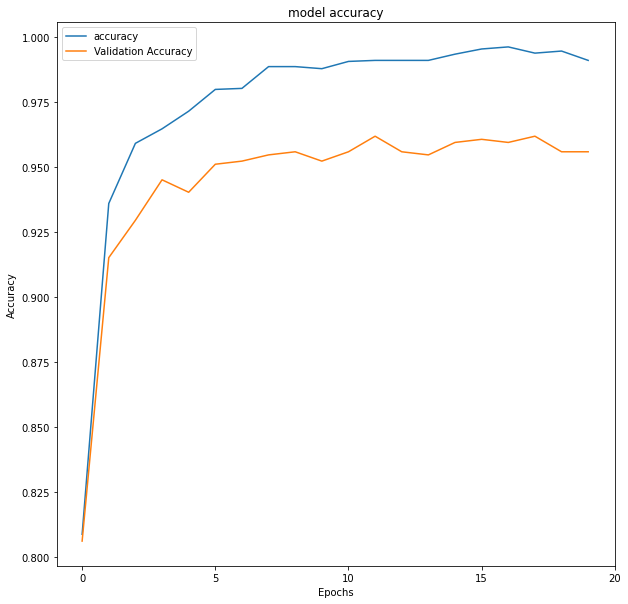

In [ ]:
plt.figure(figsize=(10, 10))
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title("model accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epochs")
plt.xticks(np.arange(0, len(hist.history['accuracy'])+1, 5))
plt.legend(["accuracy","Validation Accuracy"])
plt.show()

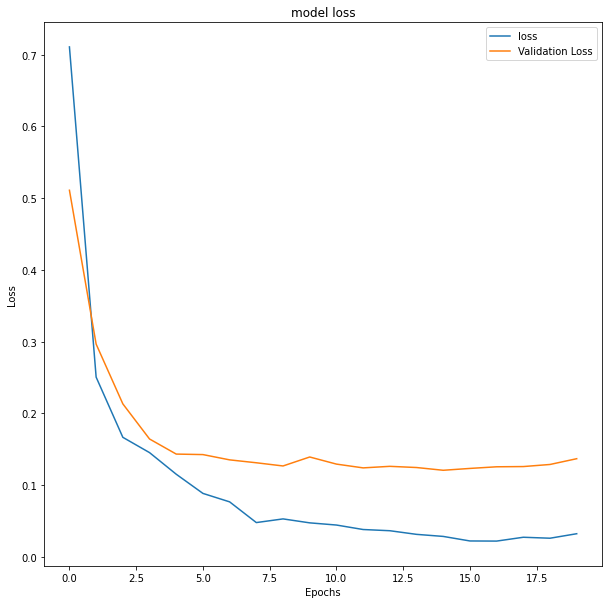

In [ ]:
plt.figure(figsize=(10, 10))
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title("model loss")
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.legend(["loss","Validation Loss"])
plt.show()

In [ ]:
_, accuarcy_effnet = final_model.evaluate(validation)
print('Accuracy of EfficientNet B2 on Test Data: %.2f%%' % ((accuarcy_effnet)*100))

27/27 [==============================] - 4s 150ms/step - loss: 0.1337 - accuracy: 0.9641
Accuracy of EfficientNet B2 on Test Data: 96.41%


In [ ]:
y_real=[]
all_pred=[]
count=0
for x,y in test:
  predict=final_model.predict(x)

  for i in predict:
    all_pred.append(np.argmax(i)+1)
  for i in y:
    i=np.argmax(i)+1
    y_real.append(i)

  if len(y_real)==len(test.filepaths):
    break

In [ ]:
target_names =[]
for key,value in test.class_indices.items():
  target_names.append(f'condition: {key}')

In [ ]:
from sklearn import metrics
report=metrics.classification_report(y_real,all_pred,target_names=target_names)
conf_efficnet2=metrics.confusion_matrix(y_real,all_pred)

In [ ]:
import itertools
def plot_confusion_matrix(cnf_matrix, numbers_type='numbers_and_percentage',
                          class_names=target_names,
                          title='Confusion Matrix of EfficientNet B2',
                          cmap=plt.cm.Blues,
                          file_name='confusionmatrix.png'):
    combined = True
    cnf_matrix_normalized = cnf_matrix.astype('float') / cnf_matrix.sum(axis=1)[:, np.newaxis]
    plt.figure(figsize=(10,10))
    plt.imshow(cnf_matrix, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, class_names, rotation=45)
    plt.yticks(tick_marks, class_names)

    thresh = 0.8*cnf_matrix.max() / 1.
    for i, j in itertools.product(range(cnf_matrix.shape[0]), range(cnf_matrix.shape[1])):
        if numbers_type == 'numbers_and_percentage':
            st1 = '{:.2f}%'.format(100 * cnf_matrix_normalized[i, j])
            st2 = '({:2d})'.format(cnf_matrix[i, j])
            plt.text(j, i, st1+st2,
                     horizontalalignment="center", verticalalignment='bottom',
                     color="white" if cnf_matrix[i, j] > thresh else "black")

        elif numbers_type == 'percentage':
            fmt = '.2f'
            plt.text(j, i, format(cnf_matrix_normalized[i, j], fmt),
                     horizontalalignment="center", verticalalignment='bottom',
                     color="white" if cnf_matrix[i, j] > thresh else "black")
        else:
            fmt = 'd'
            plt.text(j, i, format(cnf_matrix[i, j], fmt),
                     horizontalalignment="center", verticalalignment='bottom',
                     color="white" if cnf_matrix[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.savefig(file_name)

    return

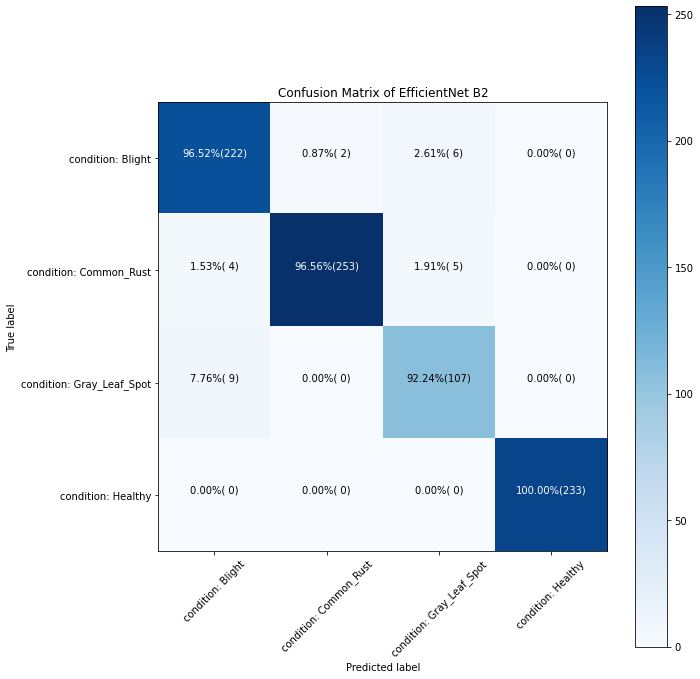

In [ ]:
plot_confusion_matrix(conf_efficnet2)

In [ ]:
# making a classification report
print('Classifiation Report of EfficientNet B2')
print(report)

Classifiation Report of EfficientNet B2
                           precision    recall  f1-score   support

        condition: Blight       0.94      0.97      0.95       230
   condition: Common_Rust       0.99      0.97      0.98       262
condition: Gray_Leaf_Spot       0.91      0.92      0.91       116
       condition: Healthy       1.00      1.00      1.00       233

                 accuracy                           0.97       841
                macro avg       0.96      0.96      0.96       841
             weighted avg       0.97      0.97      0.97       841



## Conclusion
From the confusion matrix it can be shown that the results are pretty good with an average 95% accuracy.  It can be used to detect diseases as early as possible.

In [ ]:
def configure_model(model_type):
    # inputs = tf.keras.Input(shape=(260, 260, 3))
    if model_type == 'EfficientNetB2':
        base_model = tf.keras.applications.EfficientNetB2(
            input_shape=(260, 260, 3),
            include_top=False,
            weights='imagenet'
        )
    elif model_type == 'EfficientNetV2B3':
        base_model = EfficientNetV2B3(
            input_shape=(260, 260, 3),
            include_top=False,
            weights='imagenet'
        )
    elif model_type == 'ResNet152':
        base_model = tf.keras.applications.ResNet152(
            input_shape=(260, 260, 3),
            include_top=False,
            weights='imagenet'
        )
    else:
        raise ValueError('Invalid model type')

    x = tf.keras.layers.AveragePooling2D(pool_size=(7, 7))(base_model.output)
    x = tf.keras.layers.Flatten()(x)
    outputs = tf.keras.layers.Dense(4, activation='softmax')(x)

    model = tf.keras.Model(inputs=base_model.input, outputs=outputs)
    return model

## Applying ResNet 152 Model

In [ ]:
# applying resnet 152 model
resnet152_model = configure_model('ResNet152')

In [ ]:
def model(new_model=resnet152_model,
          layers_num = 1,
          trainable=False):

    for layer in new_model.layers[:layers_num]:
        layer.trainable=trainable
    return new_model

final_model_resnet = model(resnet152_model)

In [ ]:
optimizer = tf.keras.optimizers.Adam(0.0001)

final_model_resnet.compile(optimizer=optimizer,
                    loss='categorical_crossentropy',
                    metrics=['accuracy'])

In [ ]:
EPOCHS = 50

# fitting the model to training data
hist_resnet152 = final_model_resnet.fit(train, epochs=EPOCHS,
                     validation_data=(validation),
                     callbacks=callbacks,
                     class_weight=class_weights1)

Epoch 1/50
79/79 [==============================] - 82s 852ms/step - loss: 0.4461 - accuracy: 0.8757 - val_loss: 9.5363 - val_accuracy: 0.3122

Epoch 00001: val_loss did not improve from 0.12064
Epoch 2/50
79/79 [==============================] - 65s 815ms/step - loss: 0.2318 - accuracy: 0.9407 - val_loss: 2.2896 - val_accuracy: 0.2775

Epoch 00002: val_loss did not improve from 0.12064
Epoch 3/50
79/79 [==============================] - 64s 812ms/step - loss: 0.1620 - accuracy: 0.9566 - val_loss: 3.9202 - val_accuracy: 0.2775

Epoch 00003: val_loss did not improve from 0.12064
Epoch 4/50
79/79 [==============================] - 66s 828ms/step - loss: 0.1500 - accuracy: 0.9638 - val_loss: 3.4711 - val_accuracy: 0.2775

Epoch 00004: val_loss did not improve from 0.12064
Epoch 5/50
79/79 [==============================] - 65s 819ms/step - loss: 0.0947 - accuracy: 0.9733 - val_loss: 3.6527 - val_accuracy: 0.2775

Epoch 00005: val_loss did not improve from 0.12064
Epoch 6/50
79/79 [=======

## Applying EfficientNet V2 B3

In [ ]:
effv2b3_model = configure_model('EfficientNetV2B3')

52606240/52606240 [==============================] - 4s 0us/step


In [ ]:
def model(new_model=effv2b3_model,
          layers_num = 1,
          trainable=False):
    for layer in new_model.layers[:layers_num]:
        layer.trainable=trainable
    return new_model

final_model_effv2b3 = model(effv2b3_model)

In [ ]:
optimizer = tf.keras.optimizers.Adam(0.0001)

final_model_effv2b3.compile(optimizer=optimizer,
                    loss='categorical_crossentropy',
                    metrics=['accuracy'])

In [ ]:
EPOCHS = 50

# fitting the model to training data
hist_effv2b3_model = final_model_effv2b3.fit(train, epochs=EPOCHS,
                     validation_data=(validation),
                     callbacks=callbacks,
                     class_weight=class_weights1)

Epoch 1/50
79/79 [==============================] - ETA: 0s - loss: 0.7278 - accuracy: 0.8049
Epoch 1: val_loss improved from inf to 0.48633, saving model to my_model.h5
79/79 [==============================] - 157s 880ms/step - loss: 0.7278 - accuracy: 0.8049 - val_loss: 0.4863 - val_accuracy: 0.8086 - lr: 1.0000e-04
Epoch 2/50
79/79 [==============================] - ETA: 0s - loss: 0.3385 - accuracy: 0.9044
Epoch 2: val_loss improved from 0.48633 to 0.47145, saving model to my_model.h5
79/79 [==============================] - 61s 765ms/step - loss: 0.3385 - accuracy: 0.9044 - val_loss: 0.4714 - val_accuracy: 0.8158 - lr: 1.0000e-04
Epoch 3/50
79/79 [==============================] - ETA: 0s - loss: 0.2506 - accuracy: 0.9303
Epoch 3: val_loss did not improve from 0.47145
79/79 [==============================] - 60s 757ms/step - loss: 0.2506 - accuracy: 0.9303 - val_loss: 0.9239 - val_accuracy: 0.6699 - lr: 1.0000e-04
Epoch 4/50
79/79 [==============================] - ETA: 0s - loss:

In [ ]:
_, accuarcy_effnet_v2b3 = final_model_effv2b3.evaluate(validation, verbose=0)
print('Accuracy of EfficientNet V2B3 on Test Data: %.2f%%' % ((accuarcy_effnet_v2b3)*100))

Accuracy of EfficientNet V2B3 on Test Data: 91.99%


In [ ]:
y_real=[]
all_pred=[]
count=0
for x, y in test:
  predict=final_model_effv2b3.predict(x, verbose=0)

  for i in predict:
    all_pred.append(np.argmax(i)+1)
  for i in y:
    i = np.argmax(i)+1
    y_real.append(i)

  if len(y_real)==len(test.filepaths):
    break

In [ ]:
from sklearn import metrics

In [ ]:
conf_efficnet2 = metrics.confusion_matrix(y_real, all_pred)

In [ ]:
conf_efficnet2

array([[176,   6,  44,   0],
       [  2, 259,   3,   0],
       [  5,   1, 103,   0],
       [  0,   0,   0, 242]])

In [ ]:
import itertools

def plot_confusion_matrix(cnf_matrix, numbers_type='numbers_and_percentage',
                          class_names=target_names,
                          title='Confusion Matrix of EfficientNet V2 B3',
                          cmap=plt.cm.Blues,
                          file_name='confusionmatrix.png'):
    combined = True
    cnf_matrix_normalized = cnf_matrix.astype('float') / cnf_matrix.sum(axis=1)[:, np.newaxis]
    plt.figure(figsize=(10,10))
    plt.imshow(cnf_matrix, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, class_names, rotation=45)
    plt.yticks(tick_marks, class_names)

    thresh = 0.8*cnf_matrix.max() / 1.
    for i, j in itertools.product(range(cnf_matrix.shape[0]), range(cnf_matrix.shape[1])):
        if numbers_type == 'numbers_and_percentage':
            st1 = '{:.2f}%'.format(100 * cnf_matrix_normalized[i, j])
            st2 = '({:2d})'.format(cnf_matrix[i, j])
            plt.text(j, i, st1+st2,
                     horizontalalignment="center", verticalalignment='bottom',
                     color="white" if cnf_matrix[i, j] > thresh else "black")

        elif numbers_type == 'percentage':
            fmt = '.2f'
            plt.text(j, i, format(cnf_matrix_normalized[i, j], fmt),
                     horizontalalignment="center", verticalalignment='bottom',
                     color="white" if cnf_matrix[i, j] > thresh else "black")
        else:
            fmt = 'd'
            plt.text(j, i, format(cnf_matrix[i, j], fmt),
                     horizontalalignment="center", verticalalignment='bottom',
                     color="white" if cnf_matrix[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.savefig(file_name)

    return

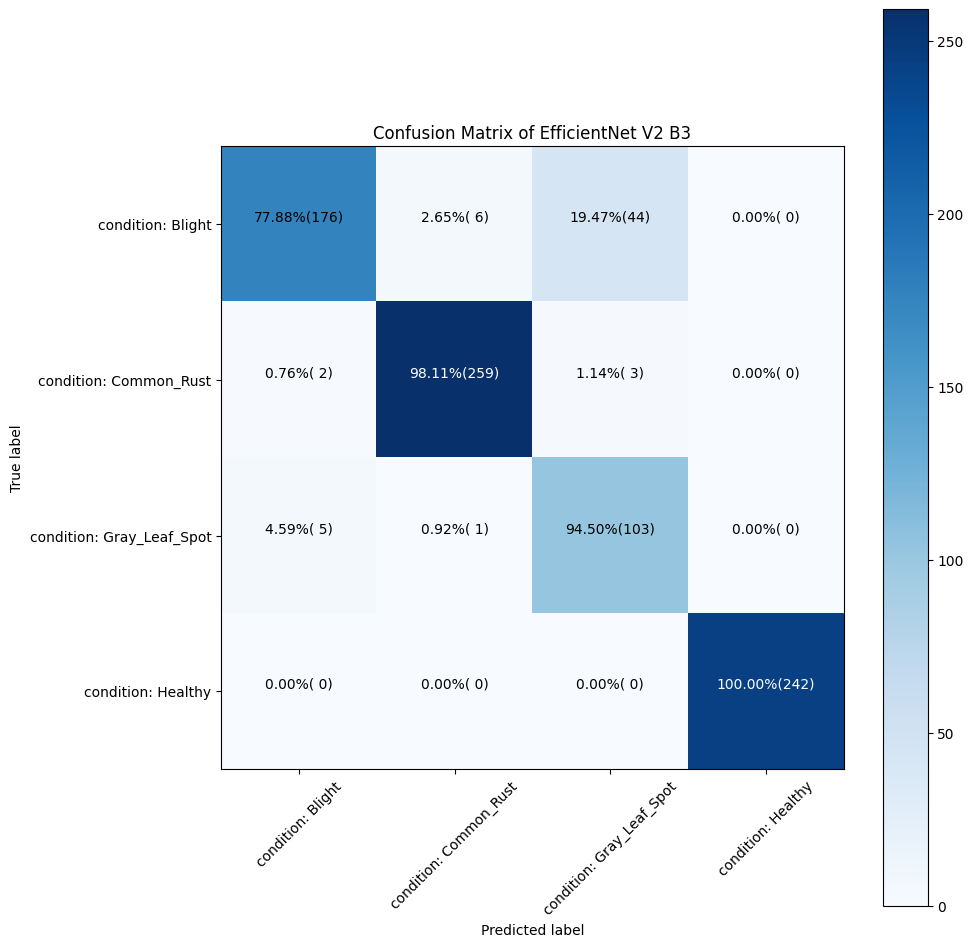

In [ ]:
plot_confusion_matrix(conf_efficnet2)

In [ ]:
report_effnetv2b3 = metrics.classification_report(y_real,
                                     all_pred,
                                     target_names=target_names)

In [ ]:
print("Classification Report of EfficientNet V2 B3")
print(report_effnetv2b3)

Classification Report of EfficientNet V2 B3
                           precision    recall  f1-score   support

        condition: Blight       0.96      0.78      0.86       226
   condition: Common_Rust       0.97      0.98      0.98       264
condition: Gray_Leaf_Spot       0.69      0.94      0.80       109
       condition: Healthy       1.00      1.00      1.00       242

                 accuracy                           0.93       841
                macro avg       0.91      0.93      0.91       841
             weighted avg       0.94      0.93      0.93       841

